读取上一步处理完成的完成图嵌入后的特征向量

In [323]:
import pickle
import numpy as np
embeddings={}
embeddings=pickle.load(open("./embeddings.pkl",'rb'))

keys=list(embeddings.keys())
values=np.array(list(embeddings.values()))


通过均方误差和轮廓系数来初步探索合适的聚类数量

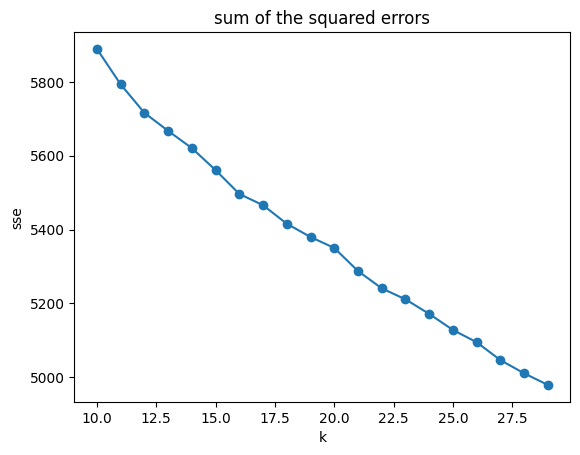

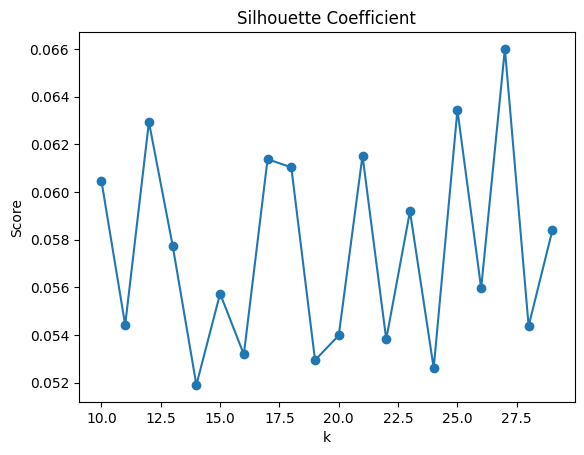

In [324]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
if True:
    x=values
    sse = []
    score = []
    K = 30
    r=5
    for k in range(10, K):
        clf = KMeans(n_clusters=k,n_init=k)
        ave_inertia=0
        ave_score=0
        for it in range(r):
            clf.fit(x)
            ave_inertia+=clf.inertia_
            lab=clf.fit_predict(x)
            ave_score+=silhouette_score(x,clf.labels_,metric='euclidean')
        sse.append(ave_inertia/r)
        score.append(ave_score/r)

    X = range(10, K)
    plt.xlabel('k')
    plt.ylabel('sse')
    plt.title('sum of the squared errors')
    plt.plot(X, sse, 'o-', )
    plt.show()
    plt.xlabel('k')
    plt.ylabel('Score')
    plt.title('Silhouette Coefficient')
    plt.plot(X, score, 'o-', )
    plt.show()

使用KMeans方法，对嵌入后的向量进行聚类分析，并且输出类别。

根据轮廓系数的提示，这里选择K=27进行聚类分析

In [465]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS


n_clusters=27

model=KMeans(n_clusters=n_clusters,n_init=n_clusters)
model.fit(values)

pred=model.predict(values)

运用TSNE对数据进行降维，并进行可视化，X是聚类中心

(688, 256)
[62, 26, 56, 62, 2, 25, 88, 20, 13, 29, 22, 13, 31, 8, 9, 43, 25, 20, 7, 14, 4, 28, 20, 8, 18, 4, 4]


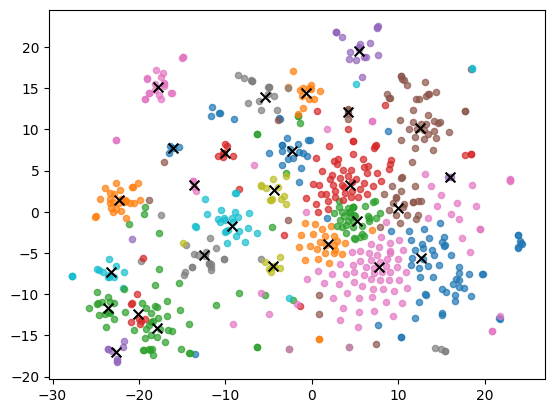

In [478]:
from sklearn.manifold import TSNE
# from sklearn.
import matplotlib.pyplot as plt
emb_list=np.array(values)
emb_list=np.append(emb_list,model.cluster_centers_,axis=0)
print(emb_list.shape)
tsne=TSNE(n_components=2)
res=tsne.fit_transform(emb_list)

colour_ind={}
for i,e in enumerate(pred):
    colour_ind.setdefault(e,[])
    colour_ind[e].append(i)
print(list(map(lambda x:len(x),colour_ind.values())))
for c,ind in colour_ind.items():
    plt.scatter(res[ind,0],res[ind,1],alpha=0.7,s=20,label=c)
plt.scatter(res[len(embeddings):len(emb_list),0],res[len(embeddings):len(emb_list),1],s=50,marker='x',c='black')
# plt.legend()
plt.show()

按照类别输出用户群体

In [479]:
# with open('./result.')
for j in range(n_clusters):
    print(*[keys[i] for i in colour_ind[j]])

egoist hasinhayder
ahmadawais posva HcySunYang Atinux michaelliao crnacura SaraVieira antfu akira-cn Akryum sdras vuejs cassidoo chriscoyier TheLarkInn chrisvfritz jishanshaikh4 midudev Asabeneh chokcoco anuraghazra SaraSoueidan bchiang7 isyuricunha jgthms
gaearon sokra jamiebuilds mjackson hzoo zpao bvaughn sebmck JedWatson sahat sophiebits kevinsawicki Rich-Harris philipwalton ljharb discord mozilla facebook leebyron vercel jordwalke chenglou tc39 audreyt nzakas felixrieseberg
justmarkham jindongwang donnemartin iamtrask chiphuyen QianMo minimaxir joelgrus mrdbourke iam-veeramalla liuhuanyong bojone giswqs jph00 TommyZihao open-mmlab eriklindernoren wepe drkostas daveshap
yyx990803 addyosmani paulirish mrdoob rauchg mathiasbynens mcollina max-mapper TooTallNate bevacqua rwaldron sindresorhus feross nat mafintosh zenorocha necolas mgechev igrigorik domenic Marak wesbos hakimel rstacruz isaacs creationix mikeal ericelliott antirez remy mattdesl jlord muan noopkat ryanflorence sebmarkba

接下来输出最靠近每个聚类中心的用户

In [480]:
n=set()
for i in range(n_clusters):
    def dis(x,y):
        return np.sqrt(np.sum(np.square(x-y)))
    centre=model.cluster_centers_[i]
    res_name=''
    res_dis=10000
    for name,pos in zip(embeddings.keys(),embeddings.values()):
        dis_now=dis(centre,pos)
        if dis_now<res_dis:
            res_name=name
            res_dis=dis_now
    print(i,res_name,res_dis)    
    n.add(res_name)
print(len(n),n_clusters)

0 egoist 1.9040103
1 JeffreyWay 1.6120821
2 DeborahK 1.4120007
3 minimaxir 1.3973083
4 JeffreyWay 1.4088141
5 Colt 0.74334437
6 jashkenas 1.0456336
7 laruence 1.5083722
8 NVIDIA 1.6593362
9 ogrisel 1.9546351
10 DIYgod 1.3400891
11 dyc87112 1.9570932
12 mattt 1.7861621
13 graydon 1.9931942
14 rochacbruno 1.100253
15 defunkt 1.7509618
16 TheCherno 1.6469955
17 JeffreyWay 0.7370209
18 twitter 1.9452118
19 tsoding 1.9042954
20 google-research 1.3348833
21 jasontaylordev 1.3451843
22 mattn 1.8907186
23 lefticus 1.5792902
24 amitshekhariitbhu 1.6817448
25 JeffreyWay 1.6825631
26 ahmetb 1.939832
24 27


可以看到有几个聚类中心的中心用户都是同一个，这表明聚类的效果可能不是那么的好。实际上有之前计算得到的轮廓系数可以看到，虽然有变化，但是绝对值都不是很大，可能的原因有几点:
1. 之前的超参数的选择不是非常的理想，导致了特征向量的差异不大
2. github用户之间的关系较为的复杂，无法非常有效的进行分类。
3. 在空间上并不是一个超球形，导致了KMeans算法无法很好的进行分类

但是由于是无监督学习，从某种角度上来讲，已经是尽力了。所以，接下来可以看看能否从这些数据里面发现什么有意思的事：

首先，将之前的user,user_int,following_list,star_list,repo_list都提取出来。

In [481]:
import pickle
import networkx as nx
graph=nx.DiGraph(pickle.load(open('./graph.pkl','rb')))
t=pickle.load(open('./data.pkl','rb'))
user,user_ind,following_list,star_list,repo_list=tuple(t)

在这里，我挑选了几个用户来进行观察。

输出距离他们最近的前几个用户都是什么

In [482]:
search = [
    "openai",
    "open-mmlab",
    "microsoft",
    "pytorch",
    "tensorflow",
    "goodfeli",
    "huggingface",
    "PaddlePaddle",
    "apple",
    "StephenGrider",
]
# print(embeddings['openai'][0:4],embeddings['google'][0:4])
for tar in search:
    if tar not in embeddings.keys():
        continue
    d = [
        (name, dis(embeddings[tar], pos))
        for name, pos in zip(embeddings.keys(), embeddings.values())
    ]
    d.sort(key=lambda x: x[1])
    print(tar, ":", *map(lambda x: x[0], d[1:20]))

    def fun(x):
        if graph.get_edge_data(x[0], tar):
            return graph.get_edge_data(x[0], tar)["weight"]
        else:
            return 0

    # print(tar,":",*map(fun,d[1:20]))

openai : NVIDIA pytorch lucidrains google-research google-deepmind huggingface ageron rbgirshick goodfeli bytedance llSourcell rsc geohot open-mmlab bojone tensorflow PaddlePaddle flutter carpedm20
open-mmlab : llSourcell bojone jtleek geohot google-deepmind PaddlePaddle campusx-official rsc pytorch google-research oschina mikeash lemire mcxiaoke geerlingguy apple insidegui StephenGrider bytedance
microsoft : open-mmlab DeborahK geerlingguy lemire oschina mikeash Azure jashkenas mhevery apple mcxiaoke StephenGrider insidegui dataprofessor campusx-official hansonwang99 mouredev rsc kubowania
pytorch : google-research NVIDIA google-deepmind goodfeli llSourcell bytedance open-mmlab rsc openai geohot lucidrains huggingface rbgirshick ageron bojone PaddlePaddle jtleek campusx-official mcxiaoke
tensorflow : goodfeli huggingface bytedance pytorch google-deepmind google-research ageron lucidrains NVIDIA flutter geohot openai open-mmlab llSourcell jtleek rsc aymericdamien iamtrask campusx-offic

在openai中，和它关系最大的前二十个用户分别是```NVIDIA pytorch lucidrains google-research google-deepmind huggingface ageron rbgirshick goodfeli bytedance llSourcell rsc geohot open-mmlab bojone tensorflow PaddlePaddle flutter carpedm20```.
其中前二是NVIDIA和pytorch，这还是非常的合理的，一个是时下非常流行的Python人工智能库，还有一个是因为CUDA技术在AI领域必不可少的显卡提供商。

再往后我们可以看到openai的竞争对手，当下AI领域的绝代双骄，谷歌的deepmind,以及其他和谷歌有关的用户。

此外还有字节跳动bytedance，据了解，字节跳动也有成立了自己的AI实验室，并且由李航等人领导。还有TensorFlow，是另外一个人工智能较为流行的库。

除了这些对我来说比较熟悉的，我又去查了查其他的一些，发现了与ai有关的一些用户:

* PaddlePaddle : 百度深度学习平台——飞桨

* open-mmlab : 深度学习时代最完整的计算机视觉开源算法体系

* huggingface : 一个在nlp领域非常有名的仓库。包含了大量的数据集。开源了transformer模型

* lucidrains : 个人的用户，使用pytorch开源了大量的模型实现，从他的库就可以看出他和pytorch的关系还是非常紧密的，都是****-pytorch的命名方式

* goodfeli : 建立的仓库中，包含了ai算法库，以及学习AI有关的资料

* ageron : Author of the book Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow. Former PM of YouTube video classification and founder & CTO of Wifirst.

这里也放出了像TensorFlow，pytorch等的用户他们相应的最接近的用户分别有哪些，就不做过多的阐述了

接下来，我想查看一个apple公司的情况，结果也在上面显示了。
```apple : insidegui nicklockwood mikeash StephenGrider vbuterin mouredev geerlingguy oschina jtleek kubowania JeffreyWay jashkenas DeborahK mcxiaoke MicrosoftDocs lydiahallie Azure hansonwang99 mhevery```

首先，令我小小惊讶的是，排名第一的竟然是一个个人开发者，查了下他的主页：

* insidegui : iOS and Mac developer.

显而易见，确实和apple的关系很大。

第二名,第三名都是和swift有关的用户，这非常合理，因为Swift是apple的一个开发语言。

但是第四名StephenGrider主要是react方向，并没有看到和apple有着什么非常大的关系。也有可能是因为有很多用户同时关注了他们两个。

记下来，我们可以通过networkx库自带的函数来查看两个用户之间的连接情况。随机选了几对来考察

这个连接是指用户之间需要经过多少**跳**才能到达。

In [483]:
pair=[('openai','NVIDIA'),('huggingface','PaddlePaddle'),('apple','insidegui'),('lucidrains','goodfeli')]
for u,v in pair:
    length=nx.dijkstra_path_length(graph.to_undirected(),u,v,weight='')
    print(u,v,length)

openai NVIDIA 2
huggingface PaddlePaddle 4
apple insidegui 2
lucidrains goodfeli 3


从这里我们可以看到，两个在嵌入后关系非常紧密的用户，其实在关系上面并不一定直接相连，很有可能要通过一系列用户的连接才能完成。
* 比方说openai和NVIDIA，两者之间并没有直接的关系，但是通过较近的几个用户之间的联系，嵌入后的特征向量还是非常靠近的
* 再比方说lucidrains和goodfeli，两人都是在ai领域贡献很大的用户，但是两者需要通过至少两个人的关系才能够建立联系。但是这两者特征向量还是非常的靠近

在这个角度上来说，本次项目所采用的的做法还是有可取之处的。

对于用户推荐任务来说，也可以以特征向量为依据，来进行推荐。

比方说，根据某人现有关注的用户，来选取靠近的这些用户的用户来达到推荐的目的

不过就目前而言这个想法是有一些局限性，比方说：
* 因为目前的算法是一个离线的算法，无法实时的更新用户的数据
* 无法将每一个人都纳入其中考虑，因为可能一个人和其他所有人的权重都没到门槛
* 能够获取的数据有限

但是就一个简易的算法而言，还是有一定的价值的